# 1. Load packages

The link to get [ImageAnalysis3](https://github.com/zhengpuas47/ImageAnalysis3) 

or the Zhuang lab archived [source_tools](https://github.com/ZhuangLab/Chromatin_Analysis_2020_cell/tree/master/sequential_tracing/source)

In [1]:
%run "C:\Users\shiwei\Documents\ImageAnalysis3\required_files\Startup_py3.py"
sys.path.append(r"C:\Users\shiwei\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

import pandas as pd

32176


See **functions** in the repository for [AnalysisTool_Chromatin](../../functions/README.md)

In [2]:
# Chromatin_analysis_tools (ATC)
# Get path for the py containing functions
import os
import sys
import importlib
module_path =r'C:\Users\shiwei\Documents\AnalysisTool_Chromatin'
if module_path not in sys.path:
    sys.path.append(module_path)
    
# import relevant modules
import gene_selection 
importlib.reload(gene_selection)
import gene_to_loci
importlib.reload(gene_to_loci)
import gene_activity
importlib.reload(gene_activity)
import loci_1d_features
importlib.reload(loci_1d_features)  

import atac_to_loci
importlib.reload(atac_to_loci)

<module 'atac_to_loci' from 'C:\\Users\\shiwei\\Documents\\AnalysisTool_Chromatin\\atac_to_loci.py'>

In [3]:
import seaborn as sns
import scanpy as sc

## 1.1 Define output folder

In [4]:
output_main_folder = r'L:\Shiwei\Figures\MOp_draft_2023_v2\AB_compartment_th_zero'
output_analysis_folder = os.path.join(output_main_folder, 'analysis')
output_figure_folder = os.path.join(output_main_folder, 'figures')

make_output_folder = True

if make_output_folder and not os.path.exists(output_analysis_folder):
    os.makedirs(output_analysis_folder)
    print(f'Generating analysis folder: {output_analysis_folder}.')
elif os.path.exists(output_analysis_folder):
    print(f'Use existing analysis folder: {output_analysis_folder}.')
    
if make_output_folder and not os.path.exists(output_figure_folder):
    os.makedirs(output_figure_folder)
    print(f'Generating figure folder: {output_figure_folder}.')
elif os.path.exists(output_figure_folder):
    print(f'Use existing figure folder: {output_figure_folder}.')


Use existing analysis folder: L:\Shiwei\Figures\MOp_draft_2023_v2\AB_compartment_th_zero\analysis.
Use existing figure folder: L:\Shiwei\Figures\MOp_draft_2023_v2\AB_compartment_th_zero\figures.


## 1.2 setting up plotting parameters

In [5]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
plt.rc('font', serif='Arial')

from ImageAnalysis3.figure_tools import _double_col_width, _single_col_width, _font_size, _ticklabel_size,_ticklabel_width

import seaborn as sns
sns.set_context("paper", rc={"font.size":_font_size,"axes.titlesize":_font_size+1,"axes.labelsize":_font_size})  

In [6]:
# cell labels from RNA-MERFISH and celltype prediction
selected_cell_labels = ['L2/3 IT','L4/5 IT','L5 IT','L6 IT','L5 ET','L5/6 NP','L6 CT','L6b',
                           'Sst','Pvalb','Lamp5','Sncg','Vip',
                           'Astro','Oligo','OPC','Micro','Endo','VLMC','SMC','Peri', 
                           #'other',
                          ]
# cell palette from RNA-MERFISH UMAP and stats
celltype_palette = {'Astro':'lightcoral', 
                    'Endo':'skyblue', 
                    'L2/3 IT':'gold', 
                    'L4/5 IT':'darkorange', 
                    'L5 ET':'mediumseagreen', 
                    'L5 IT':'aqua',
                    'L5/6 NP':'darkgreen',
                    'L6 CT':'brown',
                    'L6 IT':'magenta',
                    'L6b':'blue', 
                    'Lamp5':'orange', 
                    'Micro':'peachpuff',
                    'OPC':'thistle', 
                    'Oligo':'darkviolet',
                    'Peri':'sandybrown',
                    'Pvalb':'springgreen',
                    'SMC':'rosybrown',
                    'Sncg':'darkkhaki',
                    'Sst':'steelblue', 
                    'VLMC':'saddlebrown', 
                    'Vip':'red',
                    'other':'slategray'}


In [7]:
# this is the plotting order noted based on the snRNA transcriptional acitivty;
# we'd use this for all the graphs in this notebook
# use the snRNA data below (# section 3.1.1) if needs to re-calculate
sorted_cellplot_order = ['Micro', 'Oligo', 'Endo', 'OPC', 'Astro', 'Vip', 'Lamp5',
                  'L5/6 NP', 'Sst', 'Sncg', 'Pvalb', 'L4/5 IT', 'L6 CT',
                  'L6 IT', 'L6b', 'L2/3 IT', 'L5 IT', 'L5 ET']

# 2. Load codebook

## Codebook

Example of [codebook](../../postanalysis/0_locus_annotation/resources/MERFISH_loci_adjacent_genes_tss_more_res.csv)

In [8]:
# load codebook
# L drive is Crick Pu_SSD_0
codebook_save_folder=r'C:\Users\shiwei\Documents\AnalysisTool_Chromatin\resources'

# Load sorted codebook (allows direct matrix slicing) with cell type info
# Load codebook (then sort to allow direct matrix slicing) with cell type info

codebook_fname = os.path.join(codebook_save_folder,'MERFISH_loci_adjacent_genes_tss_more_res.csv')
codebook_df = pd.read_csv (codebook_fname, index_col=0)

# sort df temporailiy so matrix can be sliced by df order directly
codebook_df = loci_1d_features.sort_loci_df_by_chr_order (codebook_df)

codebook_df.head()

,name,id,chr,chr_order,library,dtype,adjacent_genes_0kb_tss,adjacent_genes_10kb_tss,adjacent_genes_50kb_tss,adjacent_genes_100kb_tss,adjacent_genes_200kb_tss,adjacent_genes_500kb_tss,adjacent_genes_1000kb_tss,adjacent_genes_1500kb_tss,adjacent_genes_2000kb_tss
loci_name,,,,,,,,,,,,,,,
chr1_3742742_3759944,1:3742742-3759944,1,1,0,CTP11,combo,intergenic,intergenic,intergenic,Xkr4,Xkr4,Gm18956; Gm7341; Xkr4,Gm18956; Gm2053; Gm6085; Gm6101; Gm6119; Gm734...,Atp6v1h; Gm16041; Gm17101; Gm18956; Gm2053; Gm...,Atp6v1h; Gm16041; Gm17101; Gm18956; Gm2053; Gm...
chr1_6245958_6258969,1:6245958-6258969,2,1,1,CTP11,combo,intergenic,intergenic,4732440D04Rik; Rb1cc1,4732440D04Rik; Rb1cc1,4732440D04Rik; Gm19026; Gm2147; Rb1cc1,4732440D04Rik; Gm19026; Gm2147; Npbwr1; Rb1cc1...,4732440D04Rik; Gm19026; Gm2147; Gm5694; Gm7182...,4732440D04Rik; Atp6v1h; Gm16041; Gm17101; Gm19...,4732440D04Rik; Atp6v1h; Gm16041; Gm17101; Gm19...
chr1_8740008_8759916,1:8740008-8759916,3,1,2,CTP11,combo,intergenic,intergenic,Gm15452,Gm15452,Gm15452,Gm15452,1700034P13Rik; 2610203C22Rik; Adhfe1; Gm15452;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...
chr1_9627926_9637875,1:9627926-9637875,1,1,3,CTP13,combo,2610203C22Rik,2610203C22Rik,2610203C22Rik,2610203C22Rik; Adhfe1; Gm6161; Mybl1; Rrs1,1700034P13Rik; 2610203C22Rik; Adhfe1; Gm18300;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Cops5; C...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; A830018L16Rik; A...
chr1_9799472_9811359,1:9799472-9811359,2,1,4,CTP13,combo,Gm6195,Gm6195; Sgk3,Gm6195; Sgk3,1700034P13Rik; Gm6195; Mcmdc2; Mybl1; Sgk3; Vc...,1700034P13Rik; 2610203C22Rik; Gm6195; Mcmdc2; ...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; A830018L16Rik; A...


# 3. Load RNA/ATAC average by loci

Below data can be generated from notebook:

[postanalysis/0_locus_annotation/scripts/5_majortype_atac_and_rna_means_by_loci](../../postanalysis/0_locus_annotation/scripts/5_majortype_atac_and_rna_means_by_loci.ipynb)

In [11]:
import tqdm
sel_class_list = ['Gluta','GABA','Oligo','Astro','Endo','Micro']
ref_measure_dict_byGroup = {}

for _class in tqdm.tqdm(sel_class_list):
    _class_name = _class.replace(' ','_').replace('/','_')
    #print(_class_name)
    rna_atac_fname = os.path.join(output_analysis_folder,f'MajorType_{_class_name}_snATAC_snRNA_mean_by_loci.csv')
    if os.path.exists(rna_atac_fname):
        rna_atac_df = pd.read_csv(rna_atac_fname,index_col=0)
        ref_measure_dict_byGroup[_class] = rna_atac_df

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 58.68it/s]


In [12]:
rna_atac_df

,loci_name,mean_ATAC_2X_2000kb,mean_rna_2X_2000kb,mean_rna_2X_200kb
0,chr1_3742742_3759944,1.391338,0.907407,0.462963
1,chr1_6245958_6258969,1.774731,1.925926,0.777778
2,chr1_8740008_8759916,2.144798,3.240741,0.000000
3,chr1_9627926_9637875,2.246028,2.759259,0.870370
4,chr1_9799472_9811359,2.271399,2.759259,0.703704
...,...,...,...,...
1977,chrX_166247682_166259932,2.507688,2.870370,0.666667
1978,chrX_167157164_167167452,2.485648,3.314815,1.870370
1979,chrX_168746045_168757590,2.334956,3.351852,0.574074
1980,chrX_169963295_170005197,0.875705,1.407407,0.000000


# 4. Load ABcompartment summary

Data be can be found in the repository as:

[pc_correlation_summary](../4_compartment_analysis/resources/pc_correlation_summary.csv)

[pc_correlation_summary_Endo](../4_compartment_analysis/resources/pc_correlation_summary_Endo.csv)

[pc_manual_assign_AB](../4_compartment_analysis/resources/pc_manual_assign_AB.csv)

In [13]:
postanalysis_folder = r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis_20230201\MOp_WT_postanalysis\postanalysis_vCW2_sorted'
pc_summary_fname = os.path.join(postanalysis_folder,'pc_correlation_summary.csv')
pc_manual_fname = os.path.join(postanalysis_folder,'pc_manual_assign_AB.csv')

pc_endo_fname = os.path.join(postanalysis_folder,'pc_correlation_summary_Endo.csv')

#pc_summary_dict = pickle.load(open(pc_summary_fname,'rb'))
pc_summary_df = pd.read_csv(pc_summary_fname, index_col=0)
pc_manual_df = pd.read_csv(pc_manual_fname, index_col=0)
pc_endo_df = pd.read_csv(pc_endo_fname, index_col=0)


pc_summary_allcell_df = pd.concat([pc_summary_df,pc_endo_df])

In [14]:
pc_summary_allcell_df.head()

,majorType,chr,pc1,pc2,pc1_mCH_p,pc1_mCH_r,pc1_mCG_p,pc1_mCG_r,pc2_mCH_p,pc2_mCH_r,...,pc1_RNA_p,pc1_RNA_r,pc1_ATAC_p,pc1_ATAC_r,pc2_RNA_p,pc2_RNA_r,pc2_ATAC_p,pc2_ATAC_r,pc1_explained_ratio,pc2_explained_ratio
0,Gluta,chr1,[-1.07203609 -1.0057865 -1.07295569 -0.711603...,[-0.86641222 -0.40703518 -0.61196734 -0.574909...,0.279210,0.000474,-0.536864,8.454680e-13,0.257373,0.001320,...,0.248944,1.915555e-03,0.567598,2.002877e-14,-0.332172,0.000027,-0.251292,0.001729,0.790180,0.076719
1,Gluta,chr10,[ 0.5585034 0.95432203 -0.22310143 0.510149...,[-0.95313194 -1.68530603 -1.11449662 -1.667574...,-0.184835,0.046037,-0.503318,7.301297e-09,-0.072260,0.438795,...,0.166968,7.197226e-02,0.142010,1.266782e-01,0.184904,0.045954,-0.015527,0.868034,0.666801,0.128990
2,Gluta,chr11,[ 1.17896675 1.20824079 1.15565262 1.076799...,[ 7.07711135e-01 3.02972370e-01 2.08177716e-...,-0.397955,0.000024,-0.765010,1.352895e-21,-0.446415,0.000002,...,0.621628,1.153008e-12,0.195841,4.422808e-02,0.087361,0.373209,-0.318086,0.000891,0.955323,0.018801
3,Gluta,chr12,[ 0.98294742 1.02888916 -0.5998259 -0.453684...,[-1.63996780e+00 -1.79846043e+00 -1.44297274e+...,-0.059915,0.602309,-0.649362,1.267467e-10,-0.119969,0.295461,...,0.427939,9.298827e-05,0.416254,1.503739e-04,0.298372,0.007970,0.002003,0.986117,0.877071,0.052499
4,Gluta,chr13,[-1.05917964 -1.14052145 -1.08821326 -1.137273...,[-1.40514073 -1.3350002 -1.45487391 -1.443203...,0.390778,0.000118,-0.224382,3.153373e-02,0.001570,0.988150,...,0.469154,2.390712e-06,0.677133,1.256378e-13,-0.143720,0.171696,-0.040193,0.703645,0.790589,0.114113


In [15]:
pc_manual_df

,chr,compartment_pc
majorType,,
Astro,chr1,2
Astro,chr10,1
Astro,chr11,1
Astro,chr12,1
Astro,chr13,1
...,...,...
Endo,chr6,1
Endo,chr7,1
Endo,chr8,2


In [16]:
#ensembl_pc_fname = os.path.join(postanalysis_folder,'ensemble_pc1.npy')
#ensembl_pc = np.load(ensembl_pc_fname)
#len(ensembl_pc)

1981

In [17]:
sorted_chroms = [f'chr{i}' for i in range(1,20)]
sorted_chroms.append('chrX')

# 5. Determine AB binary threshold with the binary population ATAC cutoff

## inspect binary atac cutoff

In [18]:
#rna_summary_df = pd.DataFrame(index = rna_df_dict['L2/3 IT'].index)
merged_ref_df_list = []
for _group, _rna_df in ref_measure_dict_byGroup.items():
    _rna_df['celltype']=_group
    merged_ref_df_list.append(_rna_df)

merged_ref_df = pd.concat(merged_ref_df_list)
merged_ref_df

,loci_name,mean_ATAC_2X_2000kb,mean_rna_2X_2000kb,mean_rna_2X_200kb,celltype
0,chr1_3742742_3759944,3.801971,21.495658,16.706833,Gluta
1,chr1_6245958_6258969,4.195687,11.692570,4.128430,Gluta
2,chr1_8740008_8759916,5.626522,31.264248,0.000000,Gluta
3,chr1_9627926_9637875,6.081351,38.439871,1.820276,Gluta
4,chr1_9799472_9811359,6.252073,38.439871,2.295127,Gluta
...,...,...,...,...,...
1977,chrX_166247682_166259932,2.507688,2.870370,0.666667,Micro
1978,chrX_167157164_167167452,2.485648,3.314815,1.870370,Micro
1979,chrX_168746045_168757590,2.334956,3.351852,0.574074,Micro
1980,chrX_169963295_170005197,0.875705,1.407407,0.000000,Micro


## find AB binary cutoff by correlation

In [23]:
# re-run to make sure pc signs are added
sel_ref_mode ='ATAC'

sel_ref_cols = ['majorType', 'chr',]
sel_ref_cols.extend([c for c in pc_summary_allcell_df.columns if sel_ref_mode in c])
plot_df = pc_summary_allcell_df[sel_ref_cols]

for _celltype, _type_group_df in plot_df.groupby(by = 'majorType'):
    pc_manual_df_group = pc_manual_df[pc_manual_df.index==_celltype]
    if pc_manual_df_group['chr'].tolist() == _type_group_df['chr'].tolist():
        _comp_selection = np.array(pc_manual_df_group['compartment_pc'].tolist())
        pc1_idx =  np.where(_comp_selection==1)[0]
        pc2_idx =  np.where(_comp_selection==2)[0]
        pc1_measure =  np.array(_type_group_df[f'pc1_{sel_ref_mode}_p'].tolist())
        pc2_measure =  np.array(_type_group_df[f'pc2_{sel_ref_mode}_p'].tolist())
        
        _sel_pcs = []
        _sel_pc_signs = []
        for _chr_idx in range(len(_comp_selection)):
            if _chr_idx in pc1_idx:
                _sel_pc = pc1_measure[_chr_idx]
            elif _chr_idx in pc2_idx:
                _sel_pc = pc2_measure[_chr_idx]
            # no manual selection, append nan 
            else:
                _sel_pc = np.nan
                
            if _sel_pc>=0:
                _sel_pc_sign = 1
            else:
                _sel_pc*-1
                _sel_pc_sign = -1
            _sel_pcs.append(_sel_pc)
            _sel_pc_signs.append(_sel_pc_sign)
    
    else:
        print('Mismatch for chromosome order.')
        _sel_pcs = [np.nan]*len(_type_group_df)
        _sel_pc_signs = [1]*len(_type_group_df)
        
    plot_df.loc[plot_df['majorType']==_celltype,f'selected_PC_{sel_ref_mode}_p'] = _sel_pcs
    plot_df.loc[plot_df['majorType']==_celltype,f'selected_PC_signs'] = _sel_pc_signs
    # copy the selected PC signs to the orginal df as well
    pc_summary_allcell_df.loc[pc_summary_allcell_df['majorType']==_celltype,f'selected_PC_signs'] = _sel_pc_signs


pc_summary_allcell_df.head()



group_ABs_list_dict = {}
#group_ABs_list_dict['HiC bulk'] = ensembl_pc

#for _group in contact_maps.keys():
for _celltype, _type_group_df in pc_summary_allcell_df.groupby(by = 'majorType'):
    pc_manual_df_group = pc_manual_df[pc_manual_df.index==_celltype]
    group_ABs_list = []
    for chosen_chrom in sorted_chroms:
        chosen_pc = pc_manual_df_group[pc_manual_df_group['chr']==chosen_chrom]['compartment_pc'].values
        if chosen_pc[0] in [1,2]:
            if chosen_pc[0] == 1:
                AB_chr = _type_group_df[_type_group_df['chr']==chosen_chrom]['pc1'].values
            elif chosen_pc[0] == 2:
                AB_chr = _type_group_df[_type_group_df['chr']==chosen_chrom]['pc2'].values
            AB_chr_list = AB_chr[0][1:-1].split(' ')
            AB_chr_list = [v for v in AB_chr_list if v not in ['']]
            AB_chr_list =  [np.float64(v.split('\n')[0]) for v in AB_chr_list]
        else:
            AB_chr_list = [np.nan]*len(codebook_df[codebook_df['chr']==chosen_chrom.split('chr')[1]]) # nan for the chr len
        
        _sel_pc_sign = _type_group_df.loc[_type_group_df['chr']==chosen_chrom,f'selected_PC_signs'].values
        group_ABs_list.extend(AB_chr_list*_sel_pc_sign)
    
    if len(group_ABs_list) == 1981:
        group_ABs_list_dict[_celltype] = group_ABs_list
        print (f'Result added for {_celltype}')
    else:
        print ('Error in result')

group_ABs_list_df = pd.DataFrame(group_ABs_list_dict)
group_ABs_list_df.index = codebook_df.index[:-1]
group_ABs_list_df

Result added for Astro
Result added for Endo
Result added for GABA
Result added for Gluta
Result added for Micro
Result added for Oligo


C:\Users\shiwei\AppData\Local\Temp\2\ipykernel_32176\3049160281.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df.loc[plot_df['majorType']==_celltype,f'selected_PC_{sel_ref_mode}_p'] = _sel_pcs
C:\Users\shiwei\AppData\Local\Temp\2\ipykernel_32176\3049160281.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df.loc[plot_df['majorType']==_celltype,f'selected_PC_signs'] = _sel_pc_signs


,Astro,Endo,GABA,Gluta,Micro,Oligo
loci_name,,,,,,
chr1_3742742_3759944,-0.241050,-1.412640,-1.026655,-1.072036,-1.455318,-1.246556
chr1_6245958_6258969,0.456586,-1.125234,-0.837981,-1.005786,-0.308863,-0.212538
chr1_8740008_8759916,-0.306279,-1.202867,-0.726680,-1.072956,-1.463149,-1.297032
chr1_9627926_9637875,0.529473,-1.298748,-0.929657,-0.711603,0.303482,-0.514345
chr1_9799472_9811359,1.057302,-1.067861,-0.611074,-0.560789,0.442351,0.306914
...,...,...,...,...,...,...
chrX_163750534_163758706,1.203133,0.730208,0.655811,1.091301,1.320854,1.214386
chrX_166247682_166259932,1.256300,0.697219,0.481483,1.171853,0.785380,1.140386
chrX_167157164_167167452,1.244597,1.252314,0.586619,1.357197,1.063213,1.197131


## combine all celltypes to find the AB threshold

In [25]:
#Ab_th_group_dict[sel_group]
AB_th_bulk = 0

group_ABs_id_dict = {}

for i, group_i in enumerate(group_ABs_list_dict.keys()):
    
    #sel_AB_th = Ab_th_group_dict[group_i]
    sel_AB_th = AB_th_bulk

    AB_group = np.array(group_ABs_list_dict[group_i])
    AB_ids = np.array(['unassigned'] * len(AB_group))
    AB_ids[AB_group>sel_AB_th] = 'A'
    AB_ids[AB_group<=sel_AB_th] = 'B'
    AB_ids[np.isnan(AB_group)] = 'unassigned'
    group_ABs_id_dict[group_i] = AB_ids
    
group_ABs_id_df = pd.DataFrame(group_ABs_id_dict, index =codebook_df.index[:-1])
group_ABs_id_df

,Astro,Endo,GABA,Gluta,Micro,Oligo
loci_name,,,,,,
chr1_3742742_3759944,B,B,B,B,B,B
chr1_6245958_6258969,A,B,B,B,B,B
chr1_8740008_8759916,B,B,B,B,B,B
chr1_9627926_9637875,A,B,B,B,A,B
chr1_9799472_9811359,A,B,B,B,A,A
...,...,...,...,...,...,...
chrX_163750534_163758706,A,A,A,A,A,A
chrX_166247682_166259932,A,A,A,A,A,A
chrX_167157164_167167452,A,A,A,A,A,A


## save

In [26]:
group_ABs_id_df.to_csv(os.path.join(output_analysis_folder,'AB_assignment_shared_ABth_zero.csv'))

## plot

In [27]:
group_ABs_id_df = pd.read_csv(os.path.join(output_analysis_folder,'AB_assignment_shared_ABth_zero.csv'), index_col=0)
group_ABs_id_df

,Astro,Endo,GABA,Gluta,Micro,Oligo
loci_name,,,,,,
chr1_3742742_3759944,B,B,B,B,B,B
chr1_6245958_6258969,A,B,B,B,B,B
chr1_8740008_8759916,B,B,B,B,B,B
chr1_9627926_9637875,A,B,B,B,A,B
chr1_9799472_9811359,A,B,B,B,A,A
...,...,...,...,...,...,...
chrX_163750534_163758706,A,A,A,A,A,A
chrX_166247682_166259932,A,A,A,A,A,A
chrX_167157164_167167452,A,A,A,A,A,A


In [28]:
res_summary_dict = {}
for _group, _group_AB_id in group_ABs_id_dict.items():
    res_summary_dict[_group]={'A': np.sum(_group_AB_id=='A'),'B': np.sum(_group_AB_id=='B')}
res_summary_df = pd.DataFrame(res_summary_dict).transpose()
res_summary_df['celltype'] = res_summary_df.index
res_summary_df['total'] = res_summary_df['A']+res_summary_df['B']
res_summary_df

,A,B,celltype,total
Astro,919,994,Astro,1913
Endo,940,850,Endo,1790
GABA,860,1053,GABA,1913
Gluta,911,1070,Gluta,1981
Micro,902,1011,Micro,1913
Oligo,882,972,Oligo,1854


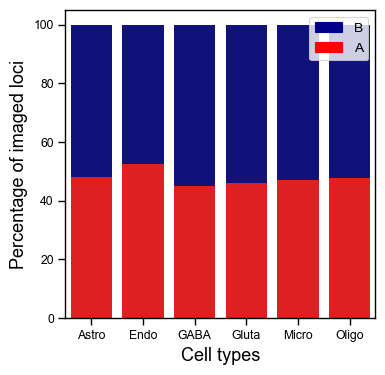

In [29]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(4,4))

# from raw value to percentage
total = res_summary_df.copy(deep=True)
A_frac = res_summary_df.copy(deep=True)
total['ratio'] = [i / j * 100 for i,j in zip(total['total'], total['total'])]
A_frac['ratio'] = [i / j * 100 for i,j in zip(A_frac['A'], total['total'])]

#total = total[~total.index.str.contains('HiC')]
#A_frac = A_frac[~A_frac.index.str.contains('HiC')]

# bar chart 1 -> top bars (group of 'smoker=No')
bar1 = sns.barplot(x="celltype",  y="ratio", data=total, color='darkblue')

# bar chart 2 -> bottom bars (group of 'smoker=Yes')
bar2 = sns.barplot(x="celltype", y="ratio", data=A_frac, color='red')

# add legend
top_bar = mpatches.Patch(color='darkblue', label='B')
bottom_bar = mpatches.Patch(color='red', label='A')
plt.legend(handles=[top_bar, bottom_bar],fontsize=10)

ax.set_ylabel('Percentage of imaged loci', fontsize=13)
ax.set_xlabel('Cell types', fontsize=13)
# show the graph
plt.show()